In [1]:
import time
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [2]:
# Mount google drive to load the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
df_5161 = pd.read_csv('/content/drive/MyDrive/tim_dataset/5161_new.csv')
df_4556 = pd.read_csv('/content/drive/MyDrive/tim_dataset/4556_new.csv')
df_4159 = pd.read_csv('/content/drive/MyDrive/tim_dataset/4159_new.csv')

In [15]:
df_5161.head(5)

,Unnamed: 0,square_id,timestamp_hourly,hourly_internet_activity
0,0,5161,2013-11-20 23:00:00,2839.123503
1,1,5161,2013-11-20 06:00:00,1508.285482
2,2,5161,2013-11-20 08:00:00,3944.749544
3,3,5161,2013-11-20 15:00:00,14417.327133
4,4,5161,2013-11-20 05:00:00,1563.353312


## PDF plot for the three square ids

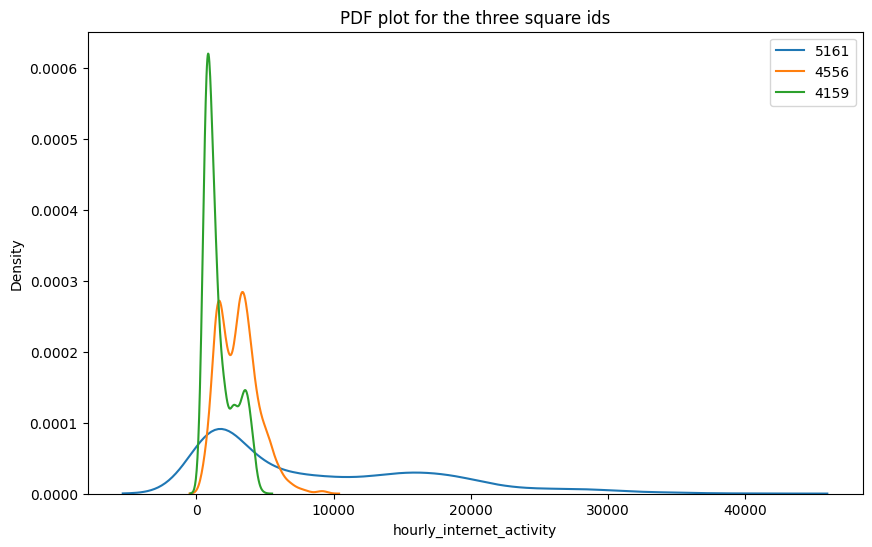

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
sns.kdeplot(df_5161['hourly_internet_activity'], ax=ax, label="5161")
sns.kdeplot(df_4556['hourly_internet_activity'], ax=ax, label="4556")
sns.kdeplot(df_4159['hourly_internet_activity'], ax=ax, label="4159")
ax.legend()
plt.title("PDF plot for the three square ids")
plt.show()

## Boxplots for the three square ids

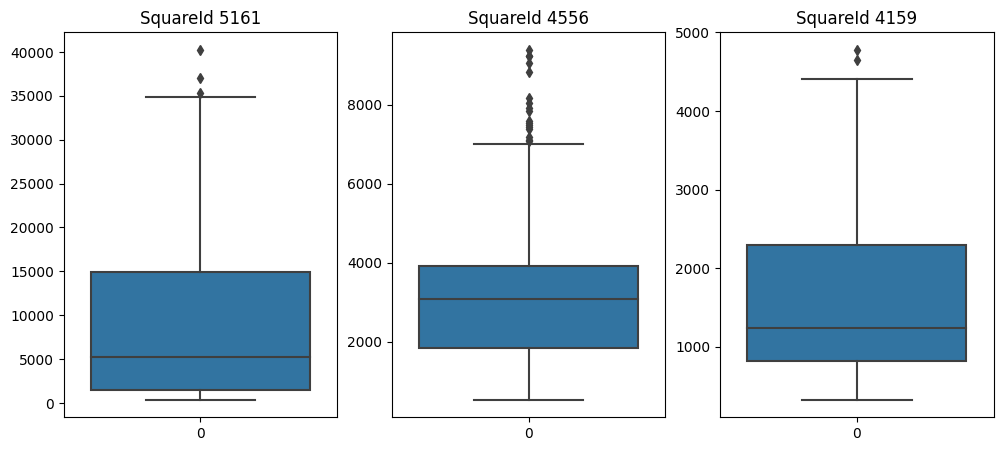

In [17]:
fig, axs = plt.subplots(1, 3, figsize = (12,5))
axs = axs.flatten()
sns.boxplot(df_5161['hourly_internet_activity'], ax=axs[0])
axs[0].set_title('SquareId 5161')
sns.boxplot(df_4556['hourly_internet_activity'], ax=axs[1])
axs[1].set_title('SquareId 4556')
sns.boxplot(df_4159['hourly_internet_activity'], ax=axs[2])
axs[2].set_title('SquareId 4159')
plt.show()

The above boxplot shows that median of the internet traffic in square id 5161 is around 5000. Approximately 75% of data traffic has value less than 15000. Any value above 35000 can be considered as outliers. While square Id 4556 and 4159 has meadian traffic around 3000 and 1300 respectively.

### Making timestamp as index

In [18]:
df_5161.drop(columns=['Unnamed: 0', 'square_id'], inplace = True)
df_5161 = df_5161.set_index('timestamp_hourly')
df_5161.index = pd.to_datetime(df_5161.index)
df_5161 = df_5161.sort_index()

df_4556.drop(columns=['Unnamed: 0', 'square_id'], inplace = True)
df_4556 = df_4556.set_index('timestamp_hourly')
df_4556.index = pd.to_datetime(df_4556.index)
df_4556 = df_4556.sort_index()

df_4159.drop(columns=['Unnamed: 0', 'square_id'], inplace = True)
df_4159 = df_4159.set_index('timestamp_hourly')
df_4159.index = pd.to_datetime(df_4159.index)
df_4159 = df_4159.sort_index()

In [19]:
df_4159.head(5)

,hourly_internet_activity
timestamp_hourly,
2013-11-01 00:00:00,1232.747479
2013-11-01 01:00:00,1225.135152
2013-11-01 02:00:00,1142.962133
2013-11-01 03:00:00,1140.047989
2013-11-01 04:00:00,966.780100


In [23]:
type(df_4159.iloc[0].index)

pandas.core.indexes.base.Index

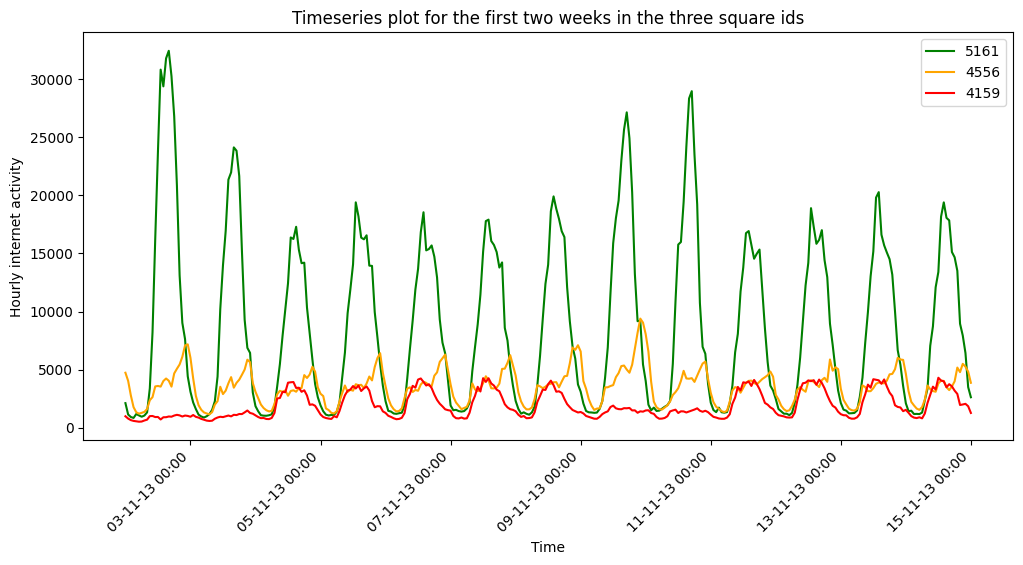

In [25]:
# start_time = pd.to_datetime('2013-11-02 00:00:00')
# end_time = pd.to_datetime('2013-11-15 00:00:00')
fig, ax = plt.subplots(figsize=(12, 6))

fig.autofmt_xdate()
xfmt = mdates.DateFormatter('%d-%m-%y %H:%M')
ax.xaxis.set_major_formatter(xfmt)

ax.plot(df_5161['2013-11-02 00:00:00':'2013-11-15 00:00:00'], label="5161", color='g')
ax.plot(df_4556['2013-11-02 00:00:00':'2013-11-15 00:00:00'], label="4556", color='orange')
ax.plot(df_4159['2013-11-02 00:00:00':'2013-11-15 00:00:00'], label="4159", color='r')

# ax.set_xlim('2013-11-02 00:00:00', '2013-11-15 00:00:00')
plt.xticks(rotation=45)
ax.legend()
plt.xlabel('Time')
plt.ylabel('Hourly internet activity')
plt.title("Timeseries plot for the first two weeks in the three square ids")
plt.show()

### Model Creation and Evaluation

In [27]:
def randomForestTimeseriesModel(time_seriesDF):
  #Create lag variables
  dataframe = DataFrame()
  for i in range(24, 0, -1):
    dataframe['t-' + str(i)] = time_seriesDF.hourly_internet_activity.shift(i)
  final_data = pd.concat([time_seriesDF, dataframe], axis=1)
  final_data.dropna(inplace=True)
  final_data['day_of_week']=final_data.index.weekday    #adding day of week feature can be helpful in better traffic prediction

  # Train-Test split
  train_data = final_data[final_data.index < '2013-12-16 00:00:00']
  test_data = final_data[(final_data.index > '2013-12-15 23:00:00') & (final_data.index < '2013-12-23 00:00:00')]
  train_data_x = train_data.loc[:, train_data.columns != 'hourly_internet_activity']
  train_data_y = train_data['hourly_internet_activity']
  test_data_x  = test_data.loc[:, train_data.columns != 'hourly_internet_activity']
  test_data_y  = test_data['hourly_internet_activity']

  param_grid = {'n_estimators': [100,200,300,500],
               'max_features': ['sqrt','log2'],
               'max_depth': [2,3,4,5]}

  # Model training
  start_time_training = time.time()
  rf_reg = RandomForestRegressor()
  rf_Grid = GridSearchCV(estimator = rf_reg, param_grid = param_grid, cv = 4)
  rf_Grid.fit(train_data_x, train_data_y)
  end_time_training = time.time()
  training_time = end_time_training-start_time_training

  # Prediction
  prediction = rf_Grid.predict(test_data_x)
  # Preapare predictions as pandas dataframe with timstamp as index
  df_predicted = DataFrame()
  df_predicted['time interval'] = test_data.index
  df_predicted['prediction'] = prediction
  df_predicted.set_index('time interval',inplace=True)
  return (test_data_y,df_predicted,training_time)

#### Random Forest hourly forcasting model for square id 5161

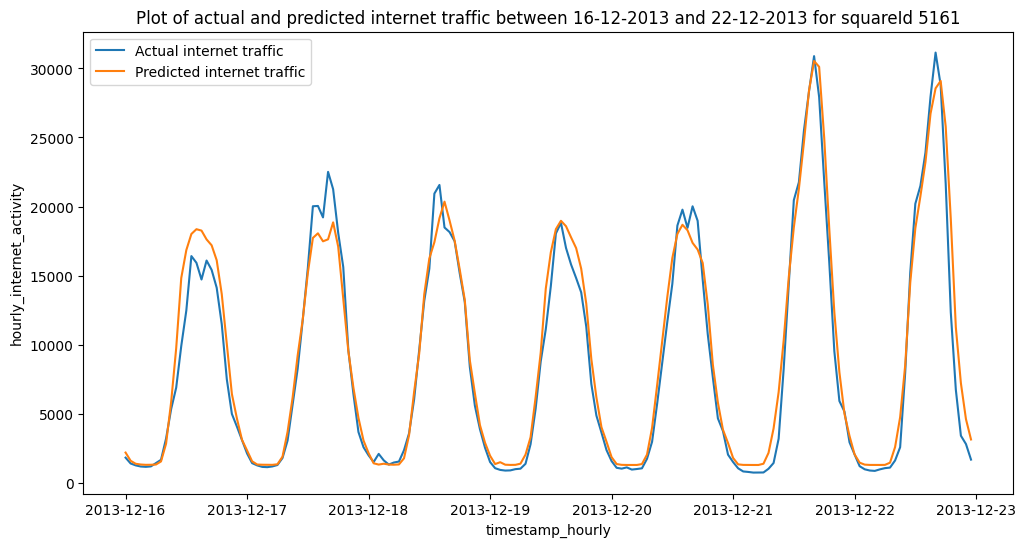

In [28]:
ex_start_5161 = time.time()
actual_5161,predicted_5161,train_time_5161 = randomForestTimeseriesModel(df_5161)
ex_end_5161 = time.time()
execution_time_5161 = ex_end_5161 - ex_start_5161

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=actual_5161, ax=ax, label="Actual internet traffic")
sns.lineplot(data=predicted_5161['prediction'], ax=ax, label="Predicted internet traffic")
ax.legend()
plt.title("Plot of actual and predicted internet traffic between 16-12-2013 and 22-12-2013 for squareId 5161")
plt.show()

In [29]:
# Train Time : squareId 5161
print('Train time of the model for squareId 5161 : {}'.format(train_time_5161))
# Execution Time : squareId 5161
print('Execution time of the model for squareId 5161 : {}'.format(execution_time_5161))
# Mean Absolute Error
mae_5161 = mean_absolute_error(actual_5161, predicted_5161['prediction'])
print('Mean Absolute Error for square id 5161 is {}'.format(mae_5161))
# Mean Absolute Percentage Error
mape_5161 = mean_absolute_percentage_error(actual_5161, predicted_5161['prediction'])
print('Mean Absolute Percentage Error for square id 5161 is {}'.format(mape_5161))

Train time of the model for squareId 5161 : 91.99740672111511
Execution time of the model for squareId 5161 : 92.05695915222168
Mean Absolute Error for square id 5161 is 1101.6269592728702
Mean Absolute Percentage Error for square id 5161 is 0.21784395010919755


#### Random Forest hourly forcasting model for square Id 4159

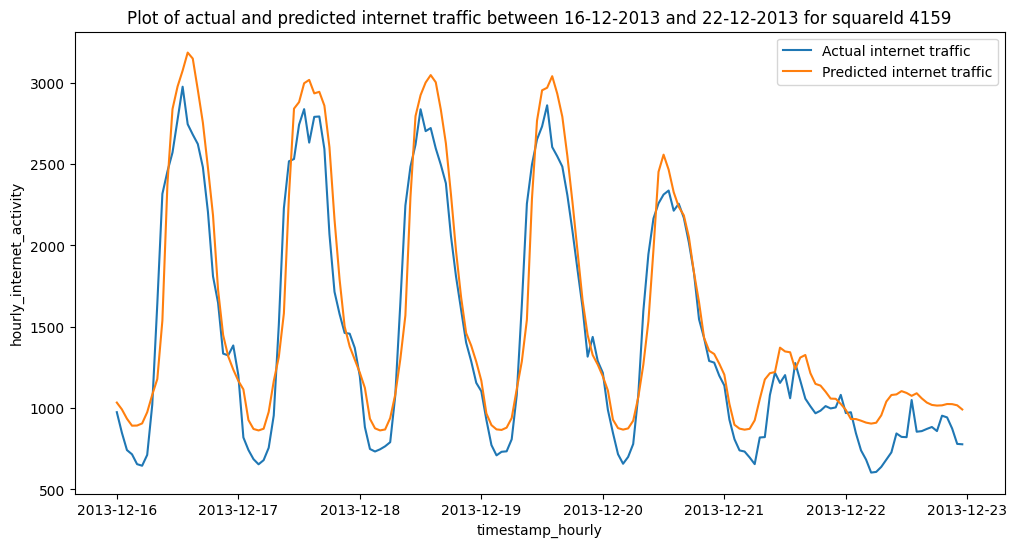

In [32]:
ex_start_4159 = time.time()
actual_4159,predicted_4159,train_time_4159 = randomForestTimeseriesModel(df_4159)
ex_end_4159 = time.time()
execution_time_4159 = ex_end_4159 - ex_start_4159

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=actual_4159, ax=ax, label="Actual internet traffic")
sns.lineplot(data=predicted_4159['prediction'], ax=ax, label="Predicted internet traffic")
ax.legend()
plt.title("Plot of actual and predicted internet traffic between 16-12-2013 and 22-12-2013 for squareId 4159")
plt.show()

In [33]:
# Train Time : squareId 4159
print('Train time of the model for squareId 4159 : {}'.format(train_time_4159))
# Execution Time : squareId 4159
print('Execution time of the model for squareId 4159 : {}'.format(execution_time_4159))
# Mean Absolute Error
mae_4159 = mean_absolute_error(actual_4159, predicted_4159['prediction'])
print('Mean Absolute Error for square id 4159 is {}'.format(mae_4159))
# Mean Absolute Percentage Error
mape_4159 = mean_absolute_percentage_error(actual_4159, predicted_4159['prediction'])
print('Mean Absolute Percentage Error for square id 4159 is {}'.format(mape_4159))

Train time of the model for squareId 4159 : 91.87119460105896
Execution time of the model for squareId 4159 : 91.99110317230225
Mean Absolute Error for square id 4159 is 189.2708801679532
Mean Absolute Percentage Error for square id 4159 is 0.1545936789631037


#### Random Forest hourly forcasting model for square id 4556

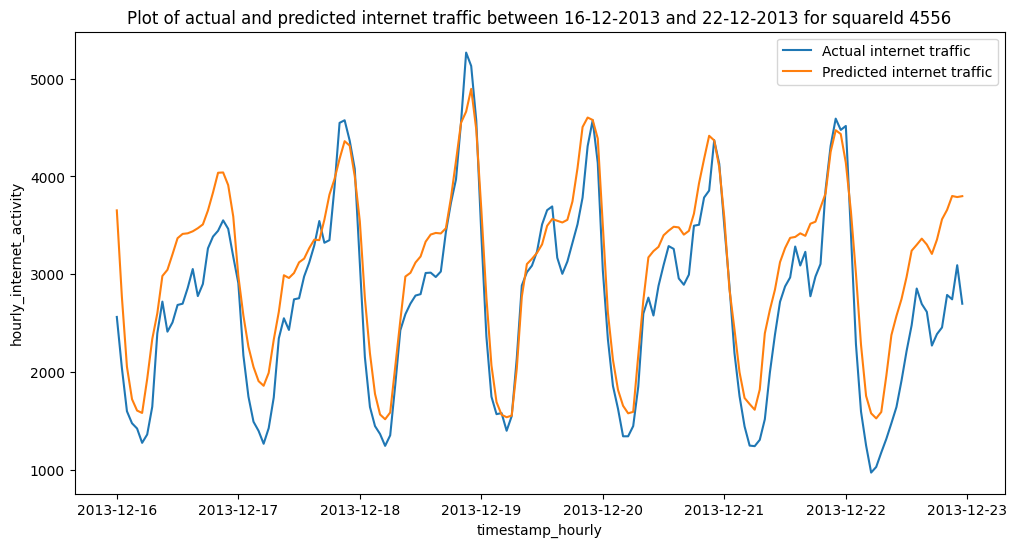

In [34]:
ex_start_4556 = time.time()
actual_4556,predicted_4556,train_time_4556 = randomForestTimeseriesModel(df_4556)
ex_end_4556 = time.time()
execution_time_4556 = ex_end_4556 - ex_start_4556

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=actual_4556, ax=ax, label="Actual internet traffic")
sns.lineplot(data=predicted_4556['prediction'], ax=ax, label="Predicted internet traffic")
ax.legend()
plt.title("Plot of actual and predicted internet traffic between 16-12-2013 and 22-12-2013 for squareId 4556")
plt.show()

In [35]:
# Train Time : squareId 4556
print('Train time of the model for squareId 4556 : {}'.format(train_time_4556))
# Execution Time : squareId 4556
print('Execution time of the model for squareId 4556 : {}'.format(execution_time_4556))
# Mean Absolute Error
mae_4556 = mean_absolute_error(actual_4556, predicted_4556['prediction'])
print('Mean Absolute Error for square id 4556 is {}'.format(mae_4556))
# Mean Absolute Percentage Error
mape_4556 = mean_absolute_percentage_error(actual_4556, predicted_4556['prediction'])
print('Mean Absolute Percentage Error for square id 4556 is {}'.format(mape_4556))

Train time of the model for squareId 4556 : 93.6788444519043
Execution time of the model for squareId 4556 : 93.8827154636383
Mean Absolute Error for square id 4556 is 393.4468983235524
Mean Absolute Percentage Error for square id 4556 is 0.17599406113782262
